# Days exceedence by basin

In [1]:
import sys
sys.path.insert(1, '../scripts/')
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
# load functions from my scripts file "ssm_utils"
from ssm_utils import get_nearest_node, reshape_fvcom3D, calc_fvcom_stat, extract_fvcom_level

# Updated method using KC results

In [2]:
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# get shapefile path    
shp = ssm['paths']['shapefile']
# load shapefile into geopandas dataframe
gdf = gpd.read_file(shp)
DO_thresh = gdf['DO_std']
DO_thresh.shape

(7494,)

In [3]:
np_operator='min'
model_var='DOXG'
processed_netcdf_dir = pathlib.Path(ssm['paths']['processed_output'])/model_var

In [4]:
import os
dir_list = os.listdir(processed_netcdf_dir)

# Load all bottom DO values into dictionary

In [5]:
MinBottomDO={}
for run_dir in dir_list:
    try: 
        run_file=processed_netcdf_dir/run_dir/'bottom'/f'daily_{np_operator}_{model_var}_bottom.nc'
        with xarray.open_dataset(run_file) as ds:
            print([*ds])
            MinBottomDO[run_dir]=ds[f'{model_var}_daily_{np_operator}_bott']
            print(MinBottomDO[run_dir].shape)
    except FileNotFoundError:
        print(f'File Not Found: {run_file}')
        # create empty placeholder for now
        MinBottomDO[run_dir]=np.ones((366, 16012))*9999

['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)
['DOXG_daily_min_bott']
(366, 16012)


## Sub-sample basin footprint

In [6]:
%%time
MinBottDO_basins={}
for run_tag in dir_list:
    MinBottDO_basins[run_tag]=MinBottomDO[run_tag][:,gdf['node_id']-1]
    if np.min(MinBottDO_basins[run_tag])==9999:
        print(f'{run_tag} min value: {np.min(MinBottDO_basins[run_tag])}')
    else:
        print(f'{run_tag} min value: {np.min(MinBottDO_basins[run_tag].values)}')
    

1c_all_sog_riv_off min value: 2.3595900984219043e-06
2b_sog_river_2times min value: 2.3576199055241887e-06
wqm_baseline min value: 2.358590108997305e-06
2a_sog_river_0.5times min value: 2.3590901037096046e-06
1d_small_sog_wwtp_off min value: 2.358619894948788e-06
1e_med_sog_wwtp_off min value: 2.358679921599105e-06
1b_all_sog_wwtp_off min value: 2.358699930482544e-06
CPU times: user 7.23 s, sys: 1min 34s, total: 1min 41s
Wall time: 1min 42s


In [7]:
MinBottDO_basins[run_tag].shape

(366, 7494)

## Create boolean where MinDO < threshold

In [8]:
nnodes = len(DO_thresh)
ndays=366
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
# (7494,366) x (7494,1) => element-wise multiplication 

In [9]:
Anoxic={}
for run_type in dir_list:
    print(run_type)
    Anoxic[run_type] = MinBottDO_basins[run_type]<=DO_thresh2D.transpose() #366x7494 (nodes x time)
    AnoxicDays[run_type]=Anoxic[run_type].sum(axis=0) #7494 (nodes)

1c_all_sog_riv_off
2b_sog_river_2times
wqm_baseline
2a_sog_river_0.5times
1d_small_sog_wwtp_off
1e_med_sog_wwtp_off
1b_all_sog_wwtp_off


In [10]:
MinBottDO_basins[run_type].shape

(366, 7494)

## Create a scatter plot of min bottom DO for Baseline to get a sense of values

In [11]:
#[ti,ni]=MinBottDO_basins[run_name].shape

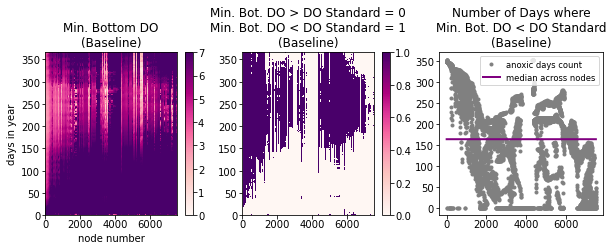

In [41]:
run_name = 'wqm_baseline'

fig, axs = plt.subplots(1,3, figsize = (10,3))
# Bottom DO    
botDO=axs[0].pcolormesh(MinBottDO_basins[run_name],cmap='RdPu', vmin=0, vmax=7)
axs[0].set_title('Min. Bottom DO\n(Baseline)')
axs[0].set_xlabel('node number')
axs[0].set_ylabel('days in year')
# Anoxic days/nodes
anox=axs[1].pcolormesh(Anoxic[run_name],cmap='RdPu', vmin=0, vmax=1)
axs[1].set_title('Min. Bot. DO > DO Standard = 0\nMin. Bot. DO < DO Standard = 1\n(Baseline)')

axs[2].plot(AnoxicDays['wqm_baseline'],
            '.',color='grey',label='anoxic days count')
axs[2].plot(np.ones(7494,)*np.median(AnoxicDays[run_name]),
            '-',color='purple',linewidth=2,label='median across nodes')
axs[2].set_title('Number of Days where\nMin. Bot. DO < DO Standard\n(Baseline)')
axs[2].legend()
cb0=fig.colorbar(botDO, ax=axs[0])
cb1=fig.colorbar(anox, ax=axs[1])
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/'Baseline_anoxia.png',
                bbox_inches='tight',format='png')

## Create pandas dataframe with Anoxic days by basin

In [23]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in dir_list:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].sum()

In [24]:
## Repeat to calculate median and min
MedianDiff={}
MinDiff={}
MaxDiff={}
AnoxicDaysDiff={}
for run_type in dir_list:
    MedianDiff[run_type]={}
    MinDiff[run_type]={}
    MaxDiff[run_type]={}
    # Difference in total number of anoxic days for each cell
    AnoxicDaysDiff[run_type] = AnoxicDays['wqm_baseline']-AnoxicDays[run_type]
    for basin in basins:
        # calculate the difference in number of anoxic days per cell
        MedianDiff[run_type][basin]=np.median(np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ])
        MinDiff[run_type][basin]=np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].min()
        MaxDiff[run_type][basin]=np.array(AnoxicDaysDiff[run_type])[
            (gdf['Basin']==basin) &
            (gdf['included_i']==1)
        ].max()

## Plot differences in the number of Anoxic days

In [25]:
[*AnoxicDaysDiff]

['1c_all_sog_riv_off',
 '2b_sog_river_2times',
 'wqm_baseline',
 '2a_sog_river_0.5times',
 '1d_small_sog_wwtp_off',
 '1e_med_sog_wwtp_off',
 '1b_all_sog_wwtp_off']

In [26]:
[*ssm]

['line_colors',
 'paths',
 'run_index',
 'run_information',
 'run_tag',
 'siglev_diff',
 'variables']

In [27]:
ssm['run_information']['run_tag']

{'1b_all_sog_wwtp_off': '1b',
 '1c_all_sog_riv_off': '1c',
 '1d_small_sog_wwtp_off': '1d',
 '1e_med_sog_wwtp_off': '1e',
 '2a_sog_river_0.5times': '2a',
 '2b_sog_river_2times': '2b',
 'wqm_baseline': 'Baseline'}

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


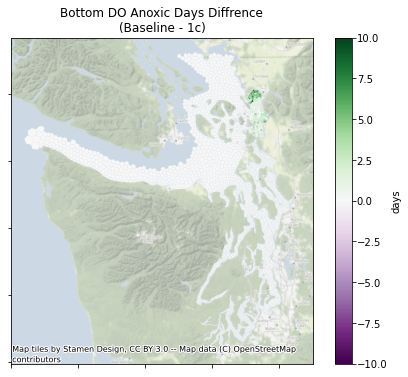

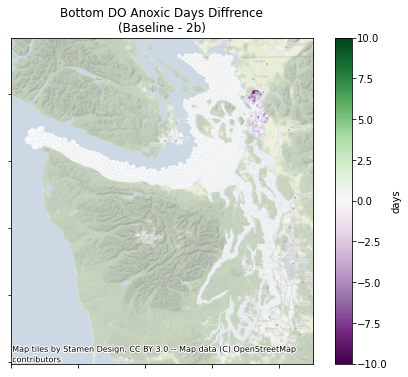

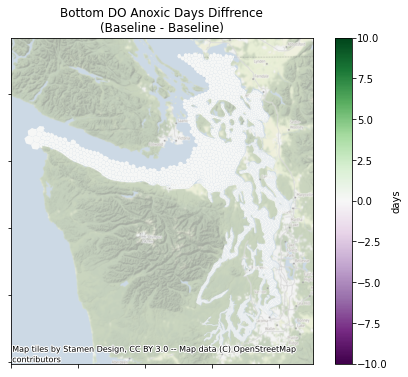

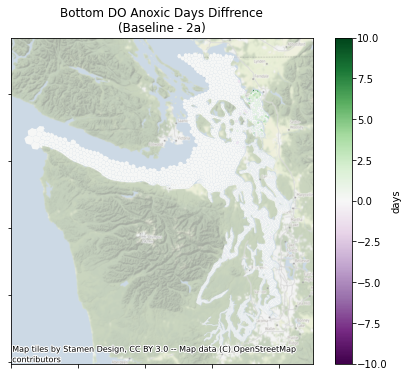

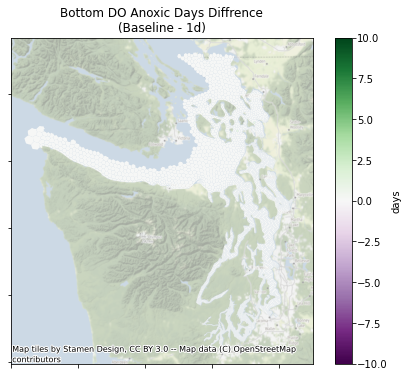

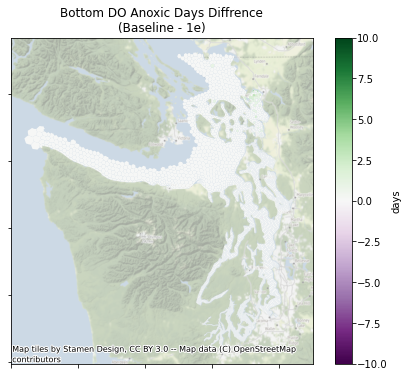

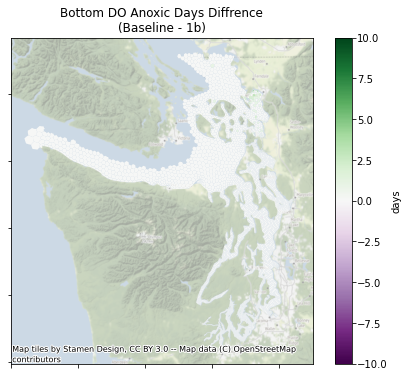

In [28]:
for idx,run in enumerate([*AnoxicDaysDiff]):
    #
    fig_title = f"Bottom DO Anoxic Days Diffrence\n(Baseline - {ssm['run_information']['run_tag'][run]})"
    graphics_name = f"AnoxDiff_Baseline_minus_{ssm['run_information']['run_tag'][run]}.png"
    gdf_col_name=f"days_diff_{ssm['run_information']['run_tag'][run]}"
    # add differences in anoxic days to geodataframe
    gdf[gdf_col_name]=AnoxicDaysDiff[run]
    # plot differences for each run
    fig, axs = plt.subplots(1,1, figsize = (8,6))
    gdf.plot(gdf_col_name, ax=axs, legend=True,vmin=-10,vmax=10,cmap='PRGn')
    cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
    # Zoom into Bbay so we can actualy see overlap
    #axs.set_ylim(5.37e6,5.42e6)
    #axs.set_xlim(5e5,5.4e5)
    #xlabels=axs.get_xticklabels()
    axs.set_title(fig_title)
    axs.set_xticklabels('')
    axs.set_yticklabels('')
    # Get colourbar from second axis
    colorbar = axs.get_figure().get_axes()[1]
    colorbar.set_ylabel('days')
    plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
                bbox_inches='tight',format='png')
    # axs.text(5.01e5,5.386e6,"Orcas Is.")
    # axs.text(5.3e5,5.405e6,"Nooksack R.")
    # axs.text(5.18e5,5.415e6,"Pt. Whitehorn")

## Plot number of anoxic days for Baseline run

[Text(0, 5150000.0, ''),
 Text(0, 5200000.0, ''),
 Text(0, 5250000.0, ''),
 Text(0, 5300000.0, ''),
 Text(0, 5350000.0, ''),
 Text(0, 5400000.0, ''),
 Text(0, 5450000.0, '')]

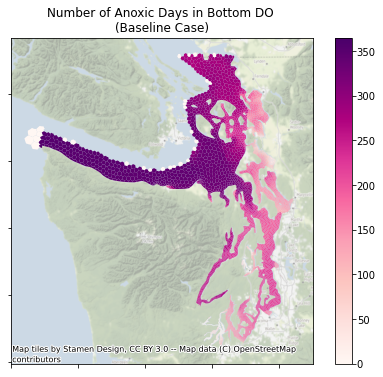

In [43]:
fig_title = f"Number of Anoxic Days in Bottom DO \n(Baseline Case)"
graphics_name = f"AnoxDays_Baseline.png"
gdf_col_name=f"days_anoxic_baseline"
# add differences in anoxic days to geodataframe
gdf[gdf_col_name]=AnoxicDays['wqm_baseline']
# plot differences for each run
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot("days_anoxic_baseline", ax=axs, legend=True,vmin=0,vmax=365,cmap='RdPu')
cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
# Zoom into Bbay so we can actualy see overlap
#axs.set_ylim(5.37e6,5.42e6)
#axs.set_xlim(5e5,5.4e5)
#xlabels=axs.get_xticklabels()
axs.set_title(fig_title)
axs.set_xticklabels('')
axs.set_yticklabels('')
# Get colourbar from second axis
#colorbar = axs.get_figure().get_axes()[1]
#colorbar.set_ylabel('days')
#plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
#            bbox_inches='tight',format='png')


In [52]:
np.median(AnoxicDays['wqm_baseline'])

164.0

In [57]:
np.sum((AnoxicDays['wqm_baseline']>350))

<xarray.DataArray 'DOXG_daily_min_bott' ()>
array(21)

In [30]:
## Map of DO_std

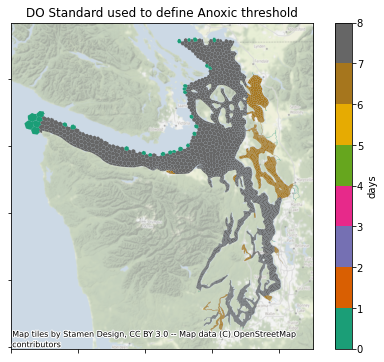

In [31]:
fig_title = f"DO Standard used to define Anoxic threshold"
graphics_name = f"DO_std.png"
# plot differences for each run
fig, axs = plt.subplots(1,1, figsize = (8,6))
gdf.plot('DO_std', ax=axs, legend=True,vmin=0,vmax=8,cmap='Dark2')
cx.add_basemap(axs, crs=gdf.crs,alpha=.5)   
# Zoom into Bbay so we can actualy see overlap
#axs.set_ylim(5.37e6,5.42e6)
#axs.set_xlim(5e5,5.4e5)
#xlabels=axs.get_xticklabels()
axs.set_title(fig_title)
axs.set_xticklabels('')
axs.set_yticklabels('')
# Get colourbar from second axis
colorbar = axs.get_figure().get_axes()[1]
colorbar.set_ylabel('days')
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/'AnoxDaysDiff'/graphics_name,
            bbox_inches='tight',format='png')



## Create and format dataframes

In [32]:
# Total number of anoxic days by basin and run
TotalAnoxic_df=pandas.DataFrame(TotalAnoxic)
TotalAnoxic_df=TotalAnoxic_df.rename(columns=ssm['run_information']['run_tag'])
TotalAnoxic_df = TotalAnoxic_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Median number of difference in anoxic days by run
MedianDiff_df = pandas.DataFrame(MedianDiff)
MedianDiff_df = MedianDiff_df.rename(columns=ssm['run_information']['run_tag'])
MedianDiff_df = MedianDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Min number of difference
MinDiff_df = pandas.DataFrame(MinDiff)
MinDiff_df = MinDiff_df.rename(columns=ssm['run_information']['run_tag'])
MinDiff_df = MinDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
# Max number of difference
MaxDiff_df = pandas.DataFrame(MaxDiff)
MaxDiff_df = MaxDiff_df.rename(columns=ssm['run_information']['run_tag'])
MaxDiff_df = MaxDiff_df.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b']) 

## Create a dataframe showing percent change in days below threshold

In [33]:
# create empty dataframe to place baseline value and percent change for all other runs
PercentChangeAnoxic = pandas.DataFrame().reindex_like(TotalAnoxic_df)
PercentChangeAnoxic['Baseline']=TotalAnoxic_df['Baseline']

# create a list of the runs for which to calculate % change
change_list=TotalAnoxic_df.columns.to_list()
change_list.remove('Baseline')
# calculate percent change
baseline='Baseline' #defined as 'wqm_baseline'
for change in change_list:
    PercentChangeAnoxic[change]=100*(
        (TotalAnoxic_df[change]-TotalAnoxic_df[baseline])/TotalAnoxic_df[baseline]
    )
# PercentChangeAnoxic['1b_all_sog_wwtp_off']=100*(
#     (TotalAnoxic_df['1b_all_sog_wwtp_off']-TotalAnoxic_df['wqm_baseline'])/TotalAnoxic_df['wqm_baseline']
# )
PercentChangeAnoxic

,Baseline,1b,1c,1d,1e,2a,2b
Hood_Canal,96059,-0.002082,0.004164,0.000000,-0.001041,0.002082,0.002082
Main_Basin,162333,-0.003080,-0.016016,0.000000,-0.001848,-0.006776,0.017248
SJF_Admiralty,227686,-0.000439,-0.000439,0.000000,-0.000439,0.000439,-0.002635
SOG_Bays,118918,-0.035318,-0.147160,-0.002523,-0.033637,-0.065591,0.147160
South_Sound,129152,-0.010840,-0.038714,-0.003097,-0.006969,-0.020906,0.054974
Whidbey_Basin,76355,-0.006548,-0.044529,-0.001310,-0.006548,-0.015716,0.048458


In [34]:
PercentChangeAnoxic=PercentChangeAnoxic.rename(columns=ssm['run_information']['run_tag'])
PercentChangeAnoxic = PercentChangeAnoxic.reindex(columns=['Baseline','1b','1c','1d','1e','2a','2b'])
PercentChangeAnoxic

,Baseline,1b,1c,1d,1e,2a,2b
Hood_Canal,96059,-0.002082,0.004164,0.000000,-0.001041,0.002082,0.002082
Main_Basin,162333,-0.003080,-0.016016,0.000000,-0.001848,-0.006776,0.017248
SJF_Admiralty,227686,-0.000439,-0.000439,0.000000,-0.000439,0.000439,-0.002635
SOG_Bays,118918,-0.035318,-0.147160,-0.002523,-0.033637,-0.065591,0.147160
South_Sound,129152,-0.010840,-0.038714,-0.003097,-0.006969,-0.020906,0.054974
Whidbey_Basin,76355,-0.006548,-0.044529,-0.001310,-0.006548,-0.015716,0.048458


In [35]:
col_short=PercentChangeAnoxic.columns.to_list()
col_short_wpercent=[f"{name} [% change]" for name in col_short if name!="Baseline"]
col_short_wpercent.insert(0,"Baseline")
col_title = {col_short[i]: col_short_wpercent[i] for i in range(len(col_short))}
col_title

{'Baseline': 'Baseline',
 '1b': '1b [% change]',
 '1c': '1c [% change]',
 '1d': '1d [% change]',
 '1e': '1e [% change]',
 '2a': '2a [% change]',
 '2b': '2b [% change]'}

In [36]:
PercentChangeAnoxic = PercentChangeAnoxic.rename(columns=col_title)
PercentChangeAnoxic

,Baseline,1b [% change],1c [% change],1d [% change],1e [% change],2a [% change],2b [% change]
Hood_Canal,96059,-0.002082,0.004164,0.000000,-0.001041,0.002082,0.002082
Main_Basin,162333,-0.003080,-0.016016,0.000000,-0.001848,-0.006776,0.017248
SJF_Admiralty,227686,-0.000439,-0.000439,0.000000,-0.000439,0.000439,-0.002635
SOG_Bays,118918,-0.035318,-0.147160,-0.002523,-0.033637,-0.065591,0.147160
South_Sound,129152,-0.010840,-0.038714,-0.003097,-0.006969,-0.020906,0.054974
Whidbey_Basin,76355,-0.006548,-0.044529,-0.001310,-0.006548,-0.015716,0.048458


In [37]:
col_short=PercentChangeAnoxic.columns.to_list()
col_short_wpercent=[f'{name} [% change]' for name in col_short if name!="Baseline"]
col_short_wpercent.insert(0,"Baseline")
col_short_wpercent

['Baseline',
 '1b [% change] [% change]',
 '1c [% change] [% change]',
 '1d [% change] [% change]',
 '1e [% change] [% change]',
 '2a [% change] [% change]',
 '2b [% change] [% change]']

## save to file

In [38]:
import openpyxl
excel_output_path = ssm['paths']['processed_output']
with pandas.ExcelWriter(pathlib.Path(excel_output_path)/'AnoxicDays.xlsx', mode='w') as writer:  
    TotalAnoxic_df.to_excel(writer, sheet_name='Total_Anoxic_Days')
    PercentChangeAnoxic.to_excel(writer, sheet_name='Percent_Change')
    MedianDiff_df.to_excel(writer, sheet_name='Median_Num_Days_Diff')
    MinDiff_df.to_excel(writer, sheet_name='Min_Num_Days_Diff')
    MaxDiff_df.to_excel(writer, sheet_name='Max_Num_Days_Diff')

# Method using 2014 output below

In [ ]:
output_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data')
graphics_directory = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics')

# Load netcdf of min daily DO on bottom level
These netcdf were output from `dev_TS_ExistRef_graphic.ipynb`

In [ ]:
%%time
MinDO={}
idx=0
# loop through comparison cases and get timeseries from model output
for run_type in ['deviation','baseline']:
    print(run_type)
    xr=xarray.open_dataset(
        output_dir/f'dailyDO_tmin_bottom_{run_type}.nc'
    )
    MinDO[run_type]=xr.DailyMinBottomDO

In [ ]:
MinDO[run_type].shape

# Load DO threshold information

In [ ]:
# with open('../etc/SSM_config.yaml', 'r') as file:
#     ssm = yaml.safe_load(file)
# # get shapefile path    
# shp = ssm['shapefile_path']
# # load shapefile into geopandas dataframe
# gdf = gpd.read_file(shp)
# gdf.head(1)

In [ ]:
# DO_thresh = gdf['DO_std']
# DO_thresh.shape

# Sub-sample model output with shapefile nodes
Assumption: array index = node_id -1
Why?  node_id = [1,16012], array index = [0,16012)

In [ ]:
MinDO[run_type].shape

In [ ]:
%%time
MinDO_basins={}
for run_type in ['deviation','baseline']:
    run_type
    MinDO_basins[run_type]=MinDO[run_type][:,gdf['node_id']-1]

In [ ]:
MinDO_basins[run_type].shape

# Create boolean where MinDO < threshold

In [ ]:
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh2D = np.ones((nnodes,ndays))*np.array(DO_thresh).reshape(nnodes,1)
# (7494,365) x (7494,1) => element-wise multiplication
for run_type in ['deviation','baseline']:
    run_type
    Anoxic = MinDO_basins[run_type].transpose()<=DO_thresh2D
    AnoxicDays[run_type]=Anoxic.sum(axis=1)

In [ ]:
AnoxicDays[run_type].median()

# Create pandas dataframe with Anoxic days by basin

In [ ]:
gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()

In [ ]:
TotalAnoxic={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalAnoxic[run_type]={}
    for basin in basins:
        TotalAnoxic[run_type][basin]=np.array(AnoxicDays[run_type])[gdf['Basin']==basin].sum()

In [ ]:
pandas.DataFrame(TotalAnoxic)

#### The above is total days where bottom DO < threshold, by basin, with "deviation" reflecting "existing" and "baseline" as "reference"

# Calculate volume days exceedence

In [ ]:
%%time
# specify variable to plot
graphic_var = 'DO'
# get correspoding model variable name, Var_10, for "DO"
ssm_var_name = ssm['var_name'][graphic_var]

for run_type in ['deviation','baseline']:
    # input netcdf filename
    index = ssm['run_index'][run_type]
    path=pathlib.Path(
        ssm['output_paths'][index])/'s_hy_base000_pnnl007_nodes.nc'
    print(path.as_posix())
    # load variable into xarray and calculate daily min.
    with xarray.open_dataset(path) as ds:
        dailyDO = reshape_fvcom(
            ds[ssm_var_name][:,:].data, 
            'days'
        ) #return (365x24xnodes)
    # calculate daily minimum (365 x nodes)
    dailyDO_tmin = calc_fvcom_stat(dailyDO, 'min', axis=1)
    # reshape to levels
    dailyDO_tmin_rshp = reshape_fvcom(dailyDO_tmin, 'levels')
    # save to file
    xr_minDO=xarray.DataArray(dailyDO_tmin_rshp, name='DailyMinDO')
    xr_minDO.to_netcdf(output_dir/f'dailyDO_24hr_min_{run_type}.nc')

In [ ]:
%%time
minDailyDO={}
for run_type in ['deviation','baseline']:
    netcdf_in = output_dir/f'dailyDO_24hr_min_{run_type}.nc'
    minDailyDO[run_type]=xarray.open_dataset(netcdf_in)

In [ ]:
minDailyDO[run_type].DailyMinDO.shape

## Use `gdf[node_id]-1` to get array indices 

In [ ]:
%%time
minDailyDO_shp={}
for run_type in ['deviation','baseline']:
    minDailyDO_shp[run_type]=minDailyDO[run_type].DailyMinDO[:,gdf['node_id']-1,:]

In [ ]:
minDailyDO_shp[run_type].shape

In [ ]:
minDailyDO_shp[run_type]

In [ ]:
minDailyDO_shp[run_type].transpose('dim_1','dim_0','dim_2').shape

## Calculate days exceedence for all layers

In [ ]:
DO_thresh = gdf['DO_std']
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)

In [ ]:
DO_thresh3D.shape

In [ ]:
DO_data = (DO_thresh3D>0)
DO_data.shape

In [ ]:
DO_data = (DO_thresh3D>0)
for depth in range(0,10):
    plt.plot(DO_thresh3D[:,1,depth][DO_data[:,1,depth]],'*')

In [ ]:
minDailyDO_shp[run_type].shape

In [ ]:
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)

In [ ]:
DO_thresh3D.shape

In [ ]:
%%time
nnodes = len(DO_thresh)
ndays=365
AnoxicDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)# (7494,365) x (7494,1) => element-wise multiplication
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)
for run_type in ['deviation','baseline']:
    print(run_type)
    Anoxic = minDailyDO_shp[run_type]<=DO_thresh3D
    AnoxicDays[run_type]=Anoxic.sum(axis=0)

### Take the max boolean value across depth (i.e. 1 if there is(are) an anoxic level(s)) 

In [ ]:
np.sum(ssm['siglev_diff'])

In [ ]:
lyr_volume_np=(np.ones((10,7494))*gdf['volume'].values).T*ssm['siglev_diff']/100

In [ ]:
lyr_volume_time_np=np.ones((365,7494,10))*lyr_volume_np

In [ ]:
lyr_volume_time_np.shape

In [ ]:
%%time
nnodes = len(DO_thresh)
ndays=365
AnoxicVolDays={}
# create array of DO_threshold values to determine number of days of noncompliance
DO_thresh3D = np.ones((nnodes,ndays,10))*np.array(DO_thresh).reshape(nnodes,1,1)# (7494,365) x (7494,1) => element-wise multiplication
DO_thresh3D=DO_thresh3D.reshape(365,7494,10)
for run_type in ['deviation','baseline']:
    print(run_type)
    Anoxic = np.squeeze([minDailyDO_shp[run_type]<=DO_thresh3D]*lyr_volume_time_np)
    AnoxicVolDays[run_type]=Anoxic.sum(axis=0).sum(axis=1)

In [ ]:
AnoxicVolDays[run_type].shape

In [ ]:
TotalVolAnoxicDays={}
basins = gdf[['node_id','Basin']].groupby('Basin').count().index.to_list()
for run_type in ['deviation','baseline']:
    TotalVolAnoxicDays[run_type]={}
    for basin in basins:
        TotalVolAnoxicDays[run_type][basin]=np.array(AnoxicVolDays[run_type])[gdf['Basin']==basin].sum()

In [ ]:
pandas.DataFrame(TotalVolAnoxicDays).rename(columns={'deviation':'existing','baseline':'reference'})

###  Total volume [m^3] of depth levels with DO < DO_std in 2014

In [ ]:
np.array(AnoxicDays[run_type])[test].sum()

In [ ]:
np.array(AnoxicDays[run_type])[gdf['Basin']==basin].shape